# Chapter 3

### Predicting house prices: a regression example

* The two previous examples were considered **classification problems**
    * Where the goal was to predict a **single discrete label** of an input data point. 

* Another common type of machine-learning problem is **regression**, 
    * Which consists of **predicting a continuous value** *instead of a *discrete label*: 
    * For instance, 
        * predicting the temperature tomorrow, given meteorological data; or 
        * predicting the time that a software project will take to complete, given its specifications.

**NOTE:** Don’t confuse **regression** and the **algorithm logistic regression**. 
* logistic regression isn’t a regression algorithm
* It’s a classification algorithm.

### The Boston Housing Price dataset

We’ll attempt to **predict the median price of homes** in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the 
* crime rate, 
* the local property tax rate, and so on. 

The dataset we’ll use has an interesting difference from the two previous examples.
* It has relatively few data points: 
    * only 506, split between 404 training samples and 102 test samples. 
* And each feature in the input data (for example, the crime rate) has a different scale. 
    * For instance, some values are proportions, which take values between 0 and 1;
    * others take values between 1 and 12, 
    * others between 0 and 100, and so on.

In [1]:
from tensorflow.keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

As we can see, we have 404 training samples and 102 test samples, each with 13 numerical features, such as 
* per capita crime rate, 
* average number of rooms per dwelling,
* accessibility to highways, and so on.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between `$10,000` and `$50,000`. If that sounds cheap, remember that this was the mid-1970s, and these prices aren’t adjusted for inflation.

### Normalizing the data

for each feature in the input data (a column in the input data matrix), we **subtract** the `mean` of the feature and **divide** by the `standard deviation`, so that the **feature is centered** around `0` and has a **unit (1) standard deviation**. This is easily done in Numpy.

In [5]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

In [6]:
train_data -= mean
train_data /= std

In [7]:
test_data -= mean
test_data /= std

In [8]:
train_data.mean()

2.6016254395785847e-15

In [9]:
test_data.mean()

0.020826991430640224

Note that the quantities used for normalizing the test data are computed using the training data. We should never use in our workflow any quantity computed on the test data, even for something as simple as data normalization.

### Building our network

Because so few samples are available, we’ll use a very small network with two hidden layers,
* each with 64 units. 

In general, the less training data we have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [11]:
def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

The network ends with a single unit and no activation (it will be a linear layer). This is
a typical setup for **scalar regression** (a regression where we’re trying to predict a single
continuous value). 

Applying an activation function would constrain the range the output can take; for instance, if we applied a **sigmoid activation** function to the last layer, the network could only learn to predict values between 0 and 1. 

Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we compile the network with the **mse loss function (mean squared error)**;
* the square of the difference between the predictions and the targets. 
* This is a widely used loss function for regression problems.

We’re also monitoring a new metric during training: **mean absolute error (MAE)**. 
* It’s the absolute value of the difference between the predictions and the targets. 
* For instance, an MAE of **0.5** on this problem would mean our predictions are off by $500
on average.

### Validating our approach using K-fold validation

To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could split the data into a training set and a validation set, as we did in the previous examples.

But because we have so few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might change a lot depending on which data points we chose to use for validation and which we chose for training: 
* the validation scores might have a high variance with regard to the validation split.
* This would prevent us from reliably evaluating our model.

The best practice in such situations is to use **K-fold cross-validation**.
* It consists of splitting the available data into K partitions (typically K = 4 or 5), 
* instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. 
* The validation score for the model used is then the average of the K validation scores obtained. 

In terms of code, this is straightforward.

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k

num_val_samples

101

In [13]:
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    start_index = i * num_val_samples
    end_index = (i + 1) * num_val_samples
    
    val_data = train_data[start_index:end_index]
    val_targets = train_targets[start_index:end_index]
    
    partial_train_data = np.concatenate([train_data[:start_index],
                                         train_data[end_index:]]
                                        ,axis=0)
    partial_train_targets = np.concatenate([train_targets[:start_index],
                                            train_targets[end_index:]],
                                           axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
all_scores

[2.1978800296783447,
 2.5743231773376465,
 3.0001378059387207,
 2.5501747131347656]

In [15]:
np.mean(all_scores)

2.5806289315223694

In [16]:
f"""The different runs do indeed show rather different validation scores, from {round(min(all_scores),2)} to {round(max(all_scores),2)}. The average ({round(np.mean(all_scores),2)}) is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation. In this case, we’re off by ${np.mean(all_scores)*1000:,.0f} on average, which is significant considering that the prices range from $10,000 to $50,000."""

'The different runs do indeed show rather different validation scores, from 2.2 to 3.0. The average (2.58) is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation. In this case, we’re off by $2,581 on average, which is significant considering that the prices range from $10,000 to $50,000.'

Let’s try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we’ll modify the training loop to save the perepoch validation score log.

In [20]:
# Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    start_index = i * num_val_samples
    end_index = (i + 1) * num_val_samples
    
    val_data = train_data[start_index:end_index]
    val_targets = train_targets[start_index:end_index]
    
    partial_train_data = np.concatenate([train_data[:start_index],
                                         train_data[end_index:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:start_index],
                                            train_targets[end_index:]],
                                           axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [21]:
len(all_mae_histories)

4

In [24]:
len(all_mae_histories[0])

500

We can then compute the average of the per-epoch MAE scores for all folds.

In [25]:
# Building the history of successive mean K-fold validation scores

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [40]:
# Altenate of above

# average_mae_history = []

# for i in range(num_epochs):
#     lst1 = []
#     for x in all_mae_histories:
#         lst1.append(x[i])
#     average_mae_history.append(np.mean(lst1))
        
        

In [42]:
len(average_mae_history)

500

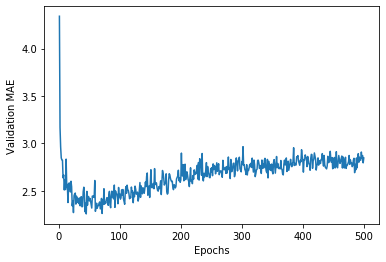

In [43]:
# Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:

1. Omit the first 10 data points, which are on a different scale than the rest of the curve.
2. Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

In [46]:
# Plotting validation scores, excluding the first 10 data points

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

In [47]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

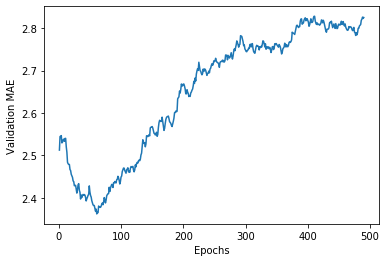

In [59]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, **`validation MAE` stops improving significantly after 80 epochs**. Past that point, model start overfitting. 

Once we’re finished tuning other parameters of the model (in addition to the number of epochs, we could also adjust the size of the hidden layers), we can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

###  Training the final model

In [60]:
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0) # Trains on the entirety of the data

In [61]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 16.8187 - mae: 2.7547


In [62]:
test_mae_score

2.7547106742858887

In [63]:
f"We’re still off by about ${test_mae_score*1000:,.0f}"

'We’re still off by about $2,755'

### Conclusion

Here’s what you should take away from this example:

* **Regression** is done using different **loss functions** than what we used for classification. **Mean squared error (MSE)** is a loss function commonly used for regression.
* Similarly, **evaluation metrics** to be used for **regression** differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is **mean absolute error (MAE)**.
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is **little data** available, using **K-fold validation** is a great way to reliably evaluate a model.
* When **little training data** is available, it’s preferable to use a **small network** with few hidden layers (typically only one or two), in order to **avoid severe overfitting**. 

### Chapter 3 summary

* We’re now able to handle the most common kinds of machine-learning tasks on vector data: 
    * binary classification, 
    * multiclass classification, and 
    * scalar regression. 

* We’ll usually need to preprocess raw data before feeding it into a neural network.
* When our data has features with different ranges, scale each feature independently as part of preprocessing.
* As training progresses, neural networks eventually begin to overfit and obtain worse results on never-before-seen data.
* If we don’t have much training data, use a small network with only one or two hidden layers, to avoid severe overfitting.
* If our data is divided into many categories, we may cause information bottlenecks if we make the intermediate layers too small.
* Regression uses different loss functions and different evaluation metrics than classification.
* When we’re working with little data, K-fold validation can help reliably evaluate our model.